# Model Verification & Assimilation

* **Verification:** It is not enough for a climate model to get the global average temperature right ($T \approx 288K$). A good model must also capture the *variability* of the system—the seasonal cycle, the year-to-year fluctuations (ENSO), and the spatial statistics.
* **Assimilation:** When we merge models with data (as in weather forecasting), we often assume that the deviations (errors) follow a Gaussian distribution. We need to check if real climate data actually behaves this way.

### Objectives
1.  **The Seasonal Cycle (Climatology):** Does the Earth 'breathe' as we expect? (`.groupby`)
2.  **Anomalies:** Removing the predictable seasons to study internal variability. (`.groupby` arithmetic)
3.  **Temporal Aggregation:** Separating 'Weather' noise from 'Climate' signals. (`.resample`)
4.  **Statistical Distributions:** Testing the Gaussian assumption for Data Assimilation. (`.plot.hist`)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ds_olr = xr.open_dataset('Datasets/CERES_TOA_OutgoingLW.nc')
ds_sw_out = xr.open_dataset('Datasets/CERES_TOA_OutgoingSW.nc')
ds_sw_in = xr.open_dataset('Datasets/CERES_TOA_IncomingSW.nc')

olr = ds_olr.toa_lw_all_mon
sw_in = ds_sw_in.solar_mon

In [2]:
olr

<xarray.DataArray 'toa_lw_all_mon' (time: 130, lat: 180, lon: 360)> Size: 34MB
[8424000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1kB 2010-03-15 2010-04-15 ... 2020-12-15
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
    standard_name:  TOA Longwave Flux - All-Sky
    CF_name:        toa_outgoing_longwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            400.000

In [3]:
sw_in

<xarray.DataArray 'solar_mon' (time: 130, lat: 180, lon: 360)> Size: 34MB
[8424000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1kB 2010-03-15 2010-04-15 ... 2020-12-15
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Incoming Solar Flux, Monthly Means
    standard_name:  Incoming Solar Flux
    CF_name:        toa_incoming_shortwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            800.000

## The Seasonal Cycle

A 0-D model is static. But the real Earth has a heartbeat. The most fundamental test for any General Circulation Model (GCM) is: **Can it reproduce the Seasonal Cycle?**

To extract this from raw data, we need to compute the **Climatology**—the average state of the system for each month of the year (e.g., the average of all Januaries, all Februaries).

### Xarray Tool: `groupby`
This works just like SQL or Pandas. We group the time series by "Month" and then average.

In [4]:
# Compute the Monthly Climatology
# This takes all time steps, groups them into 12 bins (Jan-Dec), and averages them
olr_climatology = olr.groupby('time.month').mean(dim='time')

print("Original Time Dimension:", olr.sizes['time'])
print("Climatology Time Dimension:", olr_climatology.sizes['month'])

Original Time Dimension: 130
Climatology Time Dimension: 12


### Visualizing the Energy Shift
Let's verify the **Latitudinal Transport** hypothesis. As the sun moves, does the energy budget shift?

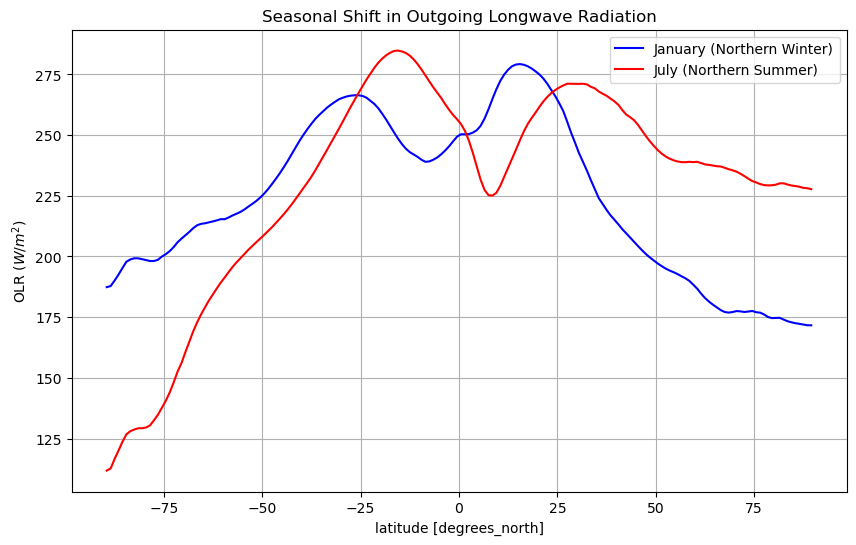

In [7]:
# Plot Zonal Mean OLR for January vs July
fig, ax = plt.subplots(figsize=(10, 6))

olr_climatology.sel(month=1).mean(dim='lon').plot(ax=ax, label='January (Northern Winter)', color='blue')
olr_climatology.sel(month=7).mean(dim='lon').plot(ax=ax, label='July (Northern Summer)', color='red')

plt.title("Seasonal Shift in Outgoing Longwave Radiation")
plt.ylabel("OLR ($W/m^2$)")
plt.legend()
plt.grid(True)
plt.show()

**THINK!:**  
Notice how in July, during NH summer, the OLR peak in NH is less than OLR peak in SH!
Same holds for January, during NH winter!

## Studying Internal Variability: Anomalies

Once we verify the mean state (Climatology), we want to study the "Internal Variability" of the system (e.g., El Niño, Weather). To do this, we must remove the predictable seasonal cycle.

$$ \text{Anomaly}(t) = \text{Observed}(t) - \text{Climatology}(\text{month}) $$

In **Data Assimilation**, this anomaly is often treated as the "error" or the "perturbation" from the background state.

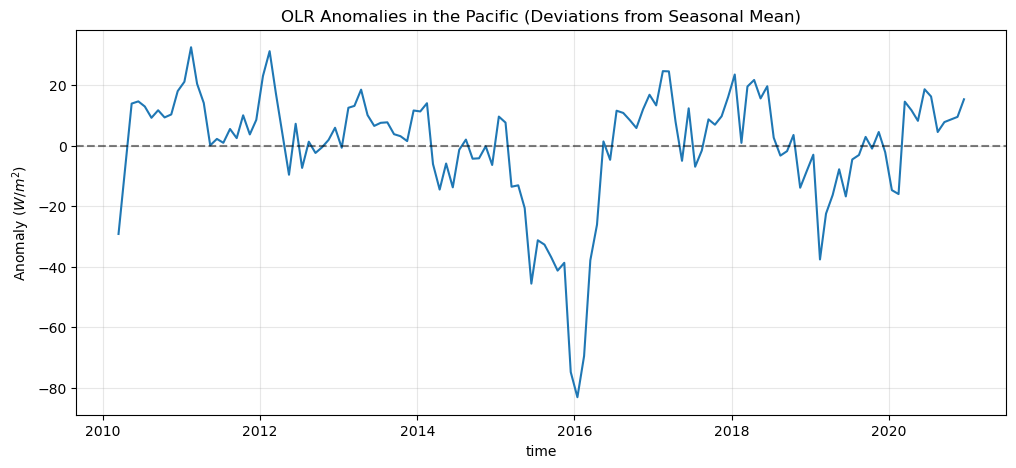

In [14]:
# Calculate Anomalies
olr_anomalies = olr.groupby('time.month') - olr_climatology

# Let's pick a point in the Pacific Ocean (El Nino region) to see the result
nino34 = olr_anomalies.sel(lat=0, lon=190, method='nearest')

plt.figure(figsize=(12, 5))
nino34.plot()
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.title("OLR Anomalies in the Pacific (Deviations from Seasonal Mean)")
plt.ylabel("Anomaly ($W/m^2$)")
plt.grid(True, alpha = 0.3)
plt.show()

## Data Assimilation: Are Errors Gaussian?

Many mathematical techniques (like Least Squares or Kalman Filters) assume that the system's variability (or error statistics) is **Gaussian (Normal)**.

If the variability is skewed (e.g., one-sided), simple assimilation methods fail. Let's check the distribution of OLR anomalies.

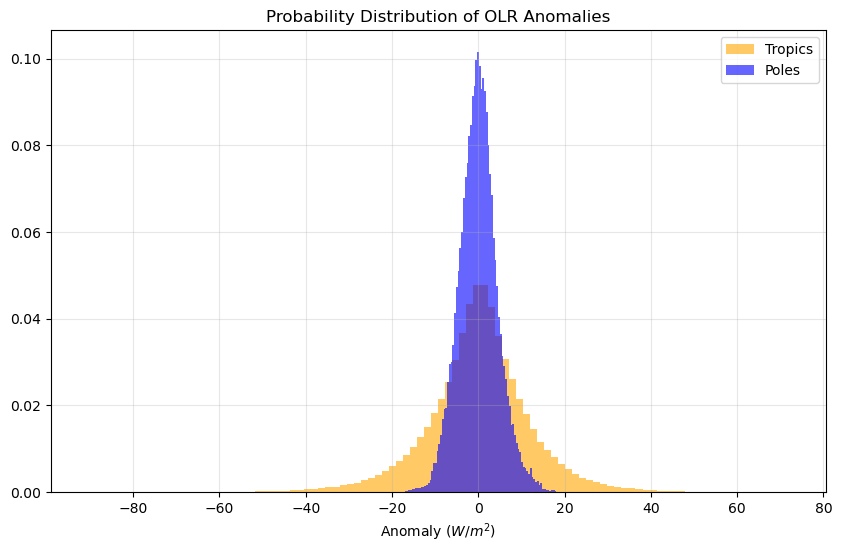

In [15]:
# Compare Tropics vs Poles
tropics_anom = olr_anomalies.sel(lat=slice(-10, 10))
poles_anom = olr_anomalies.sel(lat=slice(70, 90))

plt.figure(figsize=(10, 6))

# Flatten the data to 1D arrays for histogram plotting
plt.hist(tropics_anom.values.flatten(), bins=100, density=True, alpha=0.6, label='Tropics', color='orange')
plt.hist(poles_anom.values.flatten(), bins=100, density=True, alpha=0.6, label='Poles', color='blue')

plt.title("Probability Distribution of OLR Anomalies")
plt.xlabel("Anomaly ($W/m^2$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
import scipy.stats

# Calculate skewness along a specific dimension (e.g., 'time')
tropics_anom.reduce(func=scipy.stats.skew, dim=['time', 'lat', 'lon']), poles_anom.reduce(func=scipy.stats.skew, dim=['time', 'lat', 'lon'])   

(<xarray.DataArray 'toa_lw_all_mon' ()> Size: 4B
 array(-0.32074618, dtype=float32)
 Attributes:
     long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
     standard_name:  TOA Longwave Flux - All-Sky
     CF_name:        toa_outgoing_longwave_flux
     comment:        none
     units:          W m-2
     valid_min:            0.00000
     valid_max:            400.000,
 <xarray.DataArray 'toa_lw_all_mon' ()> Size: 4B
 array(0.17445841, dtype=float32)
 Attributes:
     long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
     standard_name:  TOA Longwave Flux - All-Sky
     CF_name:        toa_outgoing_longwave_flux
     comment:        none
     units:          W m-2
     valid_min:            0.00000
     valid_max:            400.000)

**Verification:**
* The **Poles (Blue)** are positively skewed. Why?
* The **Tropics (Orange)** are often negatively skewed. Why?

This tells us that modeling OLR requires non-Gaussian statistics!

## Signal vs Noise: Resampling

We distinguish between **Forcing** (long-term change) and **Noise** (short-term weather).

To see the "Forcing" (Climate Change), we often need to filter out the high-frequency noise. We do this by **Resampling** (changing the time resolution).

**Xarray Tool:** `.resample`
This allows us to downsample data (e.g., from Monthly to Yearly means).

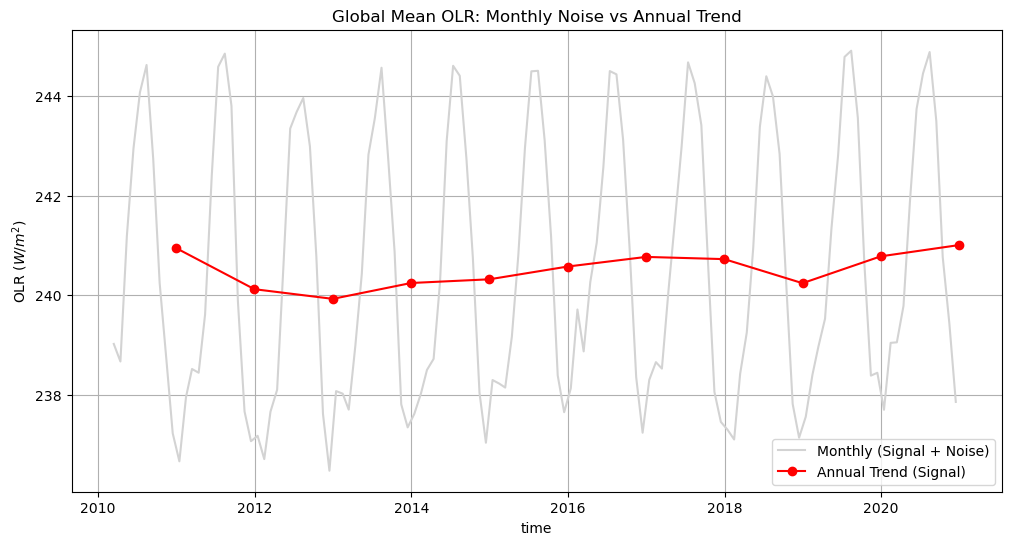

In [20]:
# Resample to Annual Means ('1Y')
olr_annual = olr.resample(time='1YE').mean()

# Create Global Weighted Average time series
weights = np.cos(np.deg2rad(olr.lat))
global_ts_monthly = olr.weighted(weights).mean(dim=['lat', 'lon'])
global_ts_annual = olr_annual.weighted(weights).mean(dim=['lat', 'lon'])

# Plot comparison
plt.figure(figsize=(12, 6))
global_ts_monthly.plot(label='Monthly (Signal + Noise)', color='lightgray')
global_ts_annual.plot(label='Annual Trend (Signal)', color='red', marker='o')

plt.title("Global Mean OLR: Monthly Noise vs Annual Trend")
plt.ylabel("OLR ($W/m^2$)")
plt.legend()
plt.grid(True)
plt.show()